In [ ]:
from leap import FastformerForCausalLM, FastformerLMConfig
from transformers import TrainingArguments, Trainer, default_data_collator
from datasets import load_dataset

from itertools import chain

In [ ]:
# t5 tokenzier, warning is nothing to worry about since we will group the texts
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-small")

C:\Users\micha\anaconda3\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
raw_datasets = load_dataset("wikitext", "wikitext-2-v1")
column_names = raw_datasets["train"].column_names
text_column_name = "text" if "text" in column_names else column_names[0]
block_size = 2048

def tokenize_function(examples):
    output = tokenizer(examples[text_column_name])
    return output

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_datasets = raw_datasets.map(
            tokenize_function,
            batched=True,
            num_proc=1,
            remove_columns=column_names,
        )

lm_dataset = tokenized_datasets.map(
    group_texts,
    batched=True,
    num_proc=1,
    desc=f"Grouping texts in chunks of {block_size}",
)

lm_dataset.set_format('pt')

Reusing dataset wikitext (C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-f37a0e1d2b8653e1.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-11f852fec431ca73.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-f34b03b1d56e9cb0.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-75498eacd22f25cc.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-0d438b212cccd

In [ ]:
# hyperparameters
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "epoch",
    evaluation_strategy ="epoch",
    save_strategy = "epoch",
    report_to = "none",
    learning_rate = 5e-4, 
    num_train_epochs = 25,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    max_grad_norm = 1,
    fp16 = True
)
# learning rates tried 1e-4, 5e-4, 1e-3
# 5e-4 yielded best results on BOTH windowed additive attention and gpt in terms of validation loss

config = FastformerLMConfig(
    hidden_size = 128,
    vocab_size = len(tokenizer),
    n_positions = block_size,
    n_heads = 4,
    n_layer = 6,
    use_local_att = False,
    window_sizes = None,
    hidden_dropout_prob = .1
)

# 1. Additive Attention adapted for causal language modeling

In [ ]:
fast_model = FastformerForCausalLM(config)

In [ ]:
pytorch_total_params = sum(p.numel() for p in fast_model.parameters() if p.requires_grad)
f'{(pytorch_total_params / 1e6):2.1f}M'

'5.5M'

In [ ]:
fast_trainer = Trainer(
    model=fast_model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["validation"]
)

fast_trainer.train()

In [ ]:
import torch
fast_model.cpu()
torch.cuda.empty_cache()

# 2. Windowed Additive Attention

In [ ]:
config = FastformerLMConfig(
    hidden_size = 128,
    vocab_size = len(tokenizer),
    n_positions = block_size,
    n_heads = 4,
    n_layer = 6,
    use_local_att = True,
    window_sizes = None, # will be set automatically
    hidden_dropout_prob = .1
)
window_model = FastformerForCausalLM(config)

In [ ]:
pytorch_total_params = sum(p.numel() for p in window_model.parameters() if p.requires_grad)
f'{(pytorch_total_params / 1e6):2.1f}M'

'5.5M'

In [ ]:
window_trainer = Trainer(
    model=window_model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["validation"]
)

window_trainer.train()

In [ ]:
import torch
window_model.cpu()
torch.cuda.empty_cache()

# 3. GPT2 (comparision)

In [ ]:
from transformers import GPT2Config, GPT2LMHeadModel
config = GPT2Config(n_embd = 128, vocab_size=len(tokenizer),
                    n_positions = block_size, n_layer = 6, n_head = 4,
                    resid_pdrop = .1, embd_pdrop = .1, attn_pdrop = .1,
                    use_cache = False 
                   )
gpt_model = GPT2LMHeadModel(config)

In [ ]:
pytorch_total_params = sum(p.numel() for p in gpt_model.parameters() if p.requires_grad)
f'{(pytorch_total_params / 1e6):2.1f}M'

'5.6M'

In [ ]:
gpt_trainer = Trainer(
    model=gpt_model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["validation"]
)

gpt_trainer.train()

# Results

In [ ]:
def format_num_param(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return f'{(total_params / 1e6):2.1f}M'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

loss1 = pd.DataFrame(fast_trainer.state.log_history[1::2]).set_index("epoch")["eval_loss"]
loss2 = pd.DataFrame(window_trainer.state.log_history[1::2]).set_index("epoch")["eval_loss"]
loss3 = pd.DataFrame(gpt_trainer.state.log_history[1::2]).set_index("epoch")["eval_loss"]
results = pd.DataFrame({f"Additive Attention ({format_num_param(fast_model)} parameters)": loss1,
                        f"Windowed Additive Attention ({format_num_param(window_model)} parameters)": loss2,
                        f"GPT2 ({format_num_param(gpt_model)} parameters)": loss3
                       })
results.to_csv("preliminary_results.csv")
results

,Additive Attention (5.5M parameters),Windowed Additive Attention (5.5M parameters),GPT2 (5.6M parameters)
epoch,,,
1.0,5.155739,5.038651,5.130702
2.0,4.918274,4.695229,4.886001
3.0,4.779167,4.492304,4.756009
4.0,4.695235,4.361029,4.664287
5.0,4.624899,4.256005,4.586405
6.0,4.564902,4.181949,4.514636
7.0,4.525072,4.120841,4.464148
8.0,4.488966,4.083940,4.419113
9.0,4.462089,4.047217,4.382271


In [ ]:
ppl_results = np.exp(results)
ppl_results

,Additive Attention (5.5M parameters),Windowed Additive Attention (5.5M parameters),GPT2 (5.6M parameters)
epoch,,,
1.0,173.423890,154.261774,169.135732
2.0,136.766340,109.423870,132.422969
3.0,119.005142,89.327047,116.280933
4.0,109.424496,78.337677,106.089926
5.0,101.992511,70.527682,98.141006
6.0,96.053164,65.493353,91.344314
7.0,92.302536,61.611008,86.846967
8.0,89.029341,59.378936,83.022585
9.0,86.668376,57.237963,80.019537


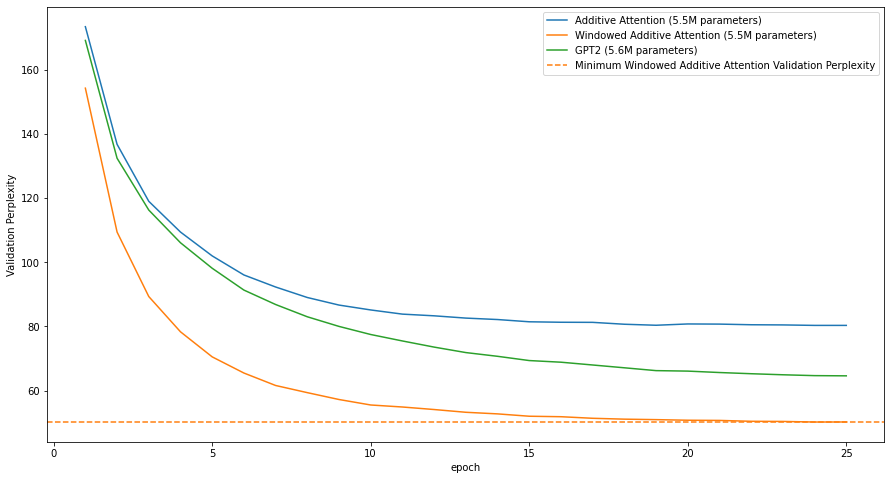

In [ ]:
ppl_results.plot()

plt.ylabel("Validation Perplexity")
plt.axhline(y=ppl_results[f"Windowed Additive Attention ({format_num_param(window_model)} parameters)"].min(),
            linestyle='--', label = "Minimum Windowed Additive Attention Validation Perplexity", color = 'C1')
plt.legend()
plt.savefig('preliminary_results.png', dpi = 100)
plt.show()

# Appendix

## Test set evaluation (DO NOT TUNE ON THIS, SHOULD ONLY BE RUN FOR BENCHMARKING PURPOSES)

In [ ]:
fast_model.cuda()
result = fast_trainer.evaluate(lm_dataset["test"])
torch.e**result["eval_loss"]

***** Running Evaluation *****
  Num examples = 151
  Batch size = 2


74.29310942743187

In [ ]:
window_model.cuda()
result = window_trainer.evaluate(lm_dataset["test"])
torch.e**result["eval_loss"]

***** Running Evaluation *****
  Num examples = 151
  Batch size = 2


47.06167739123603

In [ ]:
gpt_model.cuda()
result = gpt_trainer.evaluate(lm_dataset["test"])
torch.e**result["eval_loss"]

***** Running Evaluation *****
  Num examples = 151
  Batch size = 2


59.66087543042275

## Test code to try some text generation

In [ ]:
# test_number = 0

# input_ids = lm_dataset["test"][test_number]["input_ids"].reshape(1, -1).cpu()
# attention_mask = lm_dataset["test"][test_number]["attention_mask"].reshape(1, -1).cpu()
# labels = lm_dataset["test"][test_number]["labels"].reshape(1, -1).cpu()

In [ ]:
# test_model = window_model

# test_model = test_model.cpu().eval()
# out = test_model(input_ids=input_ids, labels = labels, attention_mask = attention_mask)
# logits = out.logits
# loss = out.loss
# loss

In [ ]:
# tokenizer.batch_decode(input_ids[:,:50])

In [ ]:
# generated_tokens = test_model.generate(input_ids[:,:50], attention_mask = attention_mask, do_sample=True, max_length=256, temperature = .7)
# tokenizer.batch_decode(generated_tokens)

## Random tuning
Short little experiment to see if other window sizes would work better, it seems the heuristic currently is use is very good and not much else performed better. The heuristic chosen after some mild testing is that window sizes should be $4*(2^{hidden\ layer\ number})$ with the last layer being global attention.

In [ ]:
# # hyperparameters
# training_args = TrainingArguments(
#     output_dir = "./results",
#     logging_strategy = "epoch",
#     evaluation_strategy ="epoch",
#     save_strategy = "epoch",
#     report_to = "none",
#     learning_rate = 5e-4,
#     num_train_epochs = 1,
#     per_device_train_batch_size = 2,
#     per_device_eval_batch_size = 2,
#     load_best_model_at_end = True,
#     metric_for_best_model = "eval_loss",
#     max_grad_norm = 1,
#     fp16 = True,
#     lr_scheduler_type = "constant"
# )

# config = FastformerLMConfig(
#     hidden_size = 128,
#     vocab_size = len(tokenizer),
#     n_positions = block_size,
#     n_heads = 4,
#     n_layer = 6,
#     use_local_att = True,
#     window_sizes = None, # set during tuning
#     hidden_dropout_prob = .1
# )

In [ ]:
# import logging
# import torch
# logging.disable(logging.INFO)

# import random
# r = random.Random(2)
# options = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

# results = []
# while True:
#     config.window_sizes = r.choices(options, k=6)
    
#     fast_model = FastformerForCausalLM(config)
#     fast_trainer = Trainer(
#         model=fast_model,
#         args=training_args,
#         data_collator=default_data_collator,
#         train_dataset=lm_dataset["train"],
#         eval_dataset=lm_dataset["validation"]
#     )

#     fast_trainer.train()
#     result = {"window_sizes": config.window_sizes, "loss": fast_trainer.state.best_metric}
#     results.append(result)
    
#     print(result)
#     del fast_model
#     del fast_trainer
#     torch.cuda.empty_cache()

In [ ]:
# import pandas as pd
# pd.DataFrame(results).sort_values(by = "loss")